# ***Facial Expression Recognition***
This notebook shows the process and orientation in building a model to recognize facial expression based on FER dataset.

This notebook was created by: ***Leor Ariel Rose, Yahav Bar David and Tal Alfi***.

### ***What Is A Facial Expression?***
Facial expression recognition is the task of classifying the expressions on face images into various categories such as anger, fear, surprise, sadness, happiness and so on.

### ***The Useage Of Facial Expression Recognition***
There are many uses for knowing what is the facial expression in an image. For example:
- Professional social networks (Linkedin) - What does our profile picture broadcasts to other people (explicitly  recruiters)?
- Social networks - How does our profile picture broadcasts to other people?
- Social networks - Detection of problematic expression (anger, sadness, etc.) of our friends and prevention of unfortunate events.
- Social networks - Confidence boost for sharing our images (if we know it shows positive expressions). 


### ***FER Dataset***
FER dataset consists of 48x48 pixel grayscale images of faces and their corresponding emotion (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

The training set consists of 28,709 examples. The public test (validation) set consists of 3,589 examples. The private test (test) set, which was used to consists of another 3,589 examples. total of 35,887 images.

This dataset was prepared by Pierre-Luc Carrier and Aaron Courville, as part of an ongoing research project.

## ***Import Libraries***

Before we begin, let's import all the necessary libraries for this notebook:

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from typing import Dict, List
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras

sns.set_theme(style="darkgrid")

## ***FER Dataset Creation***

We need to get the FER dataset that has all the images.

We will use the Kaggle API to download the FER dataset. For this you will need your Kaggle username and kaggle API token (you will need a Kaggle account). The key can then be generated via you "Accounts" page on kaggle.

<ins>**Fill in your secrets from Kaggle:**</ins>

In [ ]:
# Replace the following with your secrets
os.environ['KAGGLE_USERNAME'] = "leorrose"
os.environ['KAGGLE_KEY'] = "39c81dfbd202c9f7795874573ea4a6f9"

Now we can get the FER dataset file from kaggle:

In [ ]:
# get icml_face_data.csv from kaggle as zip
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge -f icml_face_data.csv
# extract fer2013.tar.gz
!unzip '/content/icml_face_data.csv.zip'
# delete the unnecessary zip
!rm '/content/icml_face_data.csv.zip'

 92% 89.0M/96.6M [00:01<00:00, 67.2MB/s]
100% 96.6M/96.6M [00:01<00:00, 76.9MB/s]
Archive:  /content/icml_face_data.csv.zip
  inflating: icml_face_data.csv      


## ***FER Preprocessing + EDA***

Let's load the FER csv:

In [ ]:
fer_df: pd.DataFrame = pd.read_csv('/content/icml_face_data.csv')
fer_df.columns = ["emotion", "Usage", "pixels"]

Let's display the first few rows to get to know the data better:

In [ ]:
fer_df.head(10)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,Training,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,Training,255 254 255 254 254 179 122 107 95 124 149 150...


Let's display the last few rows to get to know the data better:

In [ ]:
fer_df.tail(10)

,emotion,Usage,pixels
35877,6,PrivateTest,139 143 145 154 159 168 176 181 190 191 195 19...
35878,3,PrivateTest,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
35879,2,PrivateTest,0 0 6 16 19 31 47 18 26 19 17 8 15 3 4 2 14 20...
35880,2,PrivateTest,164 172 175 171 172 173 178 181 188 192 197 20...
35881,0,PrivateTest,181 177 176 156 178 144 136 132 122 107 131 16...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886,2,PrivateTest,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...


As we can see, each row includes:
- The image emotion.
- The image pixels values.
- Its Usage - PrivateTest (Test), PublicTest (Validation), Training.

Let's get rid of the usage column, because we will split the data to training, testing and valadition for our model:

In [ ]:
fer_df: pd.DataFrame = fer_df.drop("Usage", axis=1)
fer_df.head(5)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


Let's take a look at data balance:

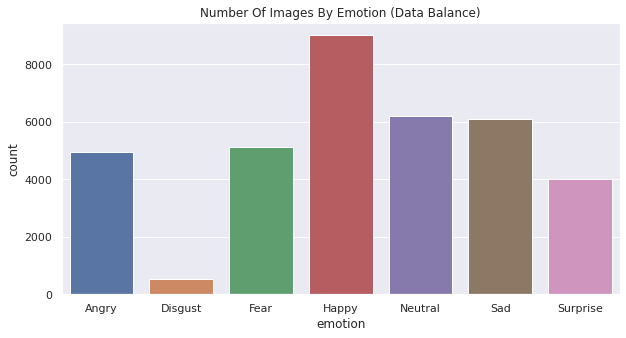

In [ ]:
# map of emotion value to string 
emotion_map: Dict[int,str] = {0:"Angry", 1:"Disgust", 2:"Fear",
                              3:"Happy", 4:"Sad", 5:"Surprise",
                              6:"Neutral"}

# create dataframe of all emotion strings
emotion_labels: pd.DataFrame = fer_df["emotion"].apply(
    lambda x: emotion_map[x])

# plot
plt.figure(figsize=(10,5))
plt.title("Number Of Images By Emotion (Data Balance)")
sns.countplot(x=emotion_labels.sort_values())
plt.show()

As we can see, most of the data is balanced but we have too much happy images and too less disgust images. Let's undersample the happy class:

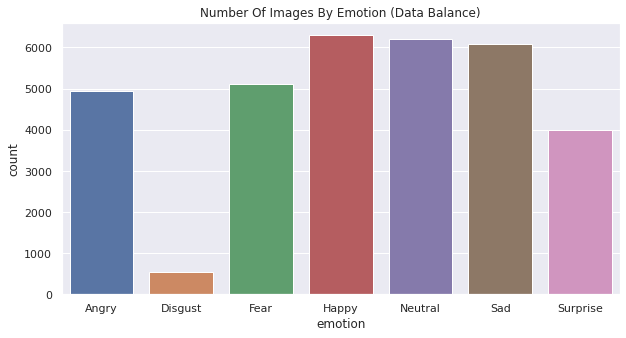

In [ ]:
# random sample 70% of the happy images
happy_df: pd.DataFrame = fer_df[fer_df["emotion"] == 3].sample(
    frac=0.7, replace=True, random_state=42)

# get all other images
other_df: pd.DataFrame = fer_df[fer_df["emotion"] != 3]
# create a dataframe with less happy images
fer_df: pd.DataFrame = pd.concat(
    [happy_df, other_df]).reset_index(drop=True)
# create dataframe of all emotion strings
emotion_labels: pd.DataFrame = fer_df["emotion"].apply(
    lambda x: emotion_map[x])

# plot
plt.figure(figsize=(10,5))
plt.title("Number Of Images By Emotion (Data Balance)")
sns.countplot(x=emotion_labels.sort_values())
plt.show()

As we can see, all of the data is balanced except disgust images. For disgust images there are two options:
1. Remove the disgust images in order to balance data but we will lose a class.
2. Leave the disgust images - can cause cause a lower classification accuracy.

Let's create images and labels from our data. We will create two sets of images and labels one with disgust and one without disgust:

In [ ]:
# create list for images
images: List[np.ndarray] = []
images_without_disgust: List[np.ndarray] = []
# create list for labels
labels: List[int] = []
labels_without_disgust: List[int] = []


# loop over all rows and get image and its corresponding label
for index, row in fer_df.iterrows():
    # split images pixels str to get a list of pixels
    image_arr: List[str] = row["pixels"].split(" ")
    # create 48 x 48 image from pixels list
    image: np.ndarray = np.asarray(
        image_arr, dtype=np.float32).reshape((48, 48))
    # append image and its corresponding label
    images.append(image)
    labels.append(row["emotion"])

    # append image and its corresponding label if not disgust
    if row["emotion"] != 1:
        images_without_disgust.append(image)
        # sort labels to be in range 0-6
        if row["emotion"] != 0:
            labels_without_disgust.append(row["emotion"] - 1)
        else:
            labels_without_disgust.append(row["emotion"])

# convert list to numpy arrays
images: np.ndarray = np.asarray(images)
labels: np.ndarray  = np.asarray(labels)
images_without_disgust: np.ndarray = np.asarray(images_without_disgust)
labels_without_disgust: np.ndarray  = np.asarray(labels_without_disgust)

Let's take a look at immages and labels shape:

In [ ]:
print(f"Images shape: {images.shape}")
print(f"Labels shape: {images.shape}")
print(f"Images (without disgust) shape: {images_without_disgust.shape}")
print(f"Labels (without disgust) shape: {labels_without_disgust.shape}")

Images shape: (33190, 48, 48)
Labels shape: (33190, 48, 48)
Images (without disgust) shape: (32643, 48, 48)
Labels (without disgust) shape: (32643,)


Let's display a few images:

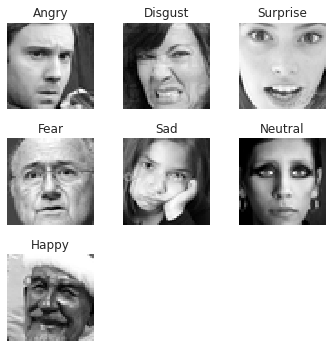

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(3, 3, figsize=(5,5))
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])

# add image 1
ax[0, 0].imshow(images[6292], cmap="gray", interpolation='nearest')
ax[0, 0].axis('off')
ax[0, 0].set_title(emotion_map[labels[6292]])

# add image 2
ax[0, 1].imshow(images[6590], cmap="gray", interpolation='nearest')
ax[0, 1].axis('off')
ax[0, 1].set_title(emotion_map[labels[6590]])

# add image 3
ax[0, 2].imshow(images[6312], cmap="gray", interpolation='nearest')
ax[0, 2].axis('off')
ax[0, 2].set_title(emotion_map[labels[6312]])

# add image 4
ax[1, 0].imshow(images[6297], cmap="gray", interpolation='nearest')
ax[1, 0].axis('off')
ax[1, 0].set_title(emotion_map[labels[6297]])

# add image 5
ax[1, 1].imshow(images[28945], cmap="gray", interpolation='nearest')
ax[1, 1].axis('off')
ax[1, 1].set_title(emotion_map[labels[28945]])

# add image 6
ax[1, 2].imshow(images[6296], cmap="gray", interpolation='nearest')
ax[1, 2].axis('off')
ax[1, 2].set_title(emotion_map[labels[6296]])

# add image 7
ax[2, 0].imshow(images[0], cmap="gray", interpolation='nearest')
ax[2, 0].axis('off')
ax[2, 0].set_title(emotion_map[labels[0]])

# plot
plt.tight_layout()
plt.show()

## ***Building The Model***

### ***Model tracking***
Before we build and test our models, let's create a dataframe to track each model accuracy:

In [ ]:
columns = ["Data with disgust class", "Data without disgust class"]
index = [
        "Transfer Learning using Xception",
        "Transfer Learning + Fine Tuning using Xception",
        "Transfer Learning using ResNet152V2",
        "Transfer Learning + Fine Tuning using ResNet152V2",
        "Transfer Learning using MobileNetV2",
        "Transfer Learning + Fine Tuning using MobileNetV2",
        "Transfer Learning using EfficientNetB0",
        "Transfer Learning + Fine Tuning using EfficientNetB0",
        "Transfer Learning using InceptionResNetV2",
        "Transfer Learning + Fine Tuning using InceptionResNetV2",
        "Self Made CNN"
]
models_df = pd.DataFrame(np.zeros((len(index), len(columns))), columns=columns, index=index)

### ***Data Includes Disgust Class***

First, let's build models with all the 7 classes (including disgust).

#### ***Model 1 - Transfer Learning using Xception***


We will create a deep neural network model to predict for each image its label  using transfer learning with a pre-trained Xception model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 96 x 96 x 3 because Xception model expects rgb images bigger than 71 x 71.
- Use Xception preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)
# resize images and change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.xception.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.xception.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 96 X 96 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- Xception without its top layers (classification layers)
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.Xception(
    weights='imagenet', input_shape=(96, 96, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(96, 96, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dropout(0.3),
     # classification layer
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 96, 96, 3)         0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 20,875,823
Trainable params: 14,343
Non-trainable params: 20,861,480
_________________________________________________________________


Now, let's compile the model using categorical crossentropy, because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
664/664 [==============================] - 96s 95ms/step - loss: 1.8222 - accuracy: 0.2738 - val_loss: 1.6260 - val_accuracy: 0.3615
Epoch 2/30
664/664 [==============================] - 61s 91ms/step - loss: 1.6955 - accuracy: 0.3365 - val_loss: 1.6026 - val_accuracy: 0.3698
Epoch 3/30
664/664 [==============================] - 61s 91ms/step - loss: 1.6783 - accuracy: 0.3413 - val_loss: 1.5579 - val_accuracy: 0.4007
Epoch 4/30
664/664 [==============================] - 61s 91ms/step - loss: 1.6562 - accuracy: 0.3556 - val_loss: 1.5589 - val_accuracy: 0.3911
Epoch 5/30
664/664 [==============================] - 61s 91ms/step - loss: 1.6523 - accuracy: 0.3526 - val_loss: 1.5590 - val_accuracy: 0.3965
Epoch 6/30
664/664 [==============================] - 61s 91ms/step - loss: 1.6571 - accuracy: 0.3482 - val_loss: 1.5476 - val_accuracy: 0.4059
Epoch 7/30
664/664 [==============================] - 61s 91ms/step - loss: 1.6475 - accuracy: 0.3593 - val_loss: 1.5663 - val_accuracy:

Now, let's visualize our model performance:

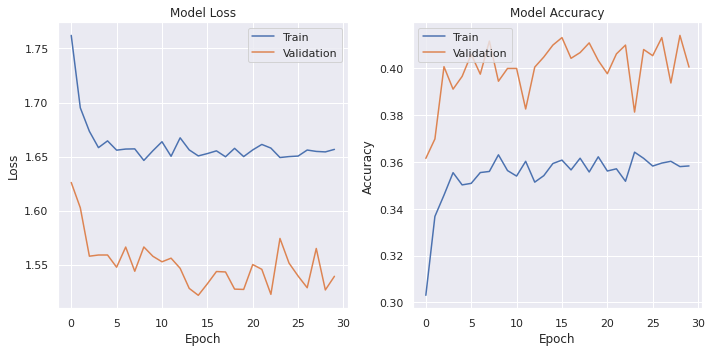

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 15s 74ms/step - loss: 1.5403 - accuracy: 0.4078
Model loss: 1.540343999862671
Model accuracy 0.40780356526374817


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

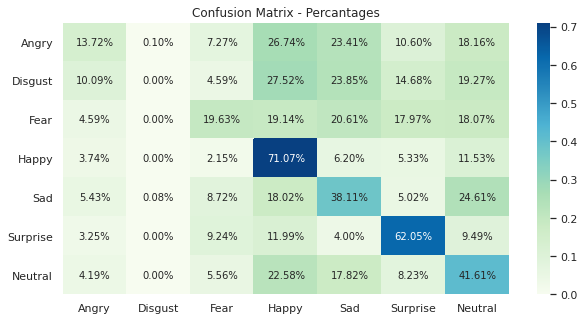

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry, Disgust, Fear and a little difficulty classifying Sad and Neutral.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning using Xception",
               "Data with disgust class"] = model_eval[1]

#### ***Model 2 - Transfer Learning + Fine Tuning using Xception***


We will create a deep neural network model to predict for each image its label  using transfer learning and Fine tuning with a pre-trained Xception model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 96 x 96 x 3 because Xception model expects rgb images bigger than 71 x 71.
- Use Xception preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)
# resize images and change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.xception.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.xception.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 96 X 96 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- Xception without its top layers (classification layers) - with trainable layers to allow fine tuning.
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.Xception(
    weights='imagenet', input_shape=(96, 96, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = True

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(96, 96, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dropout(0.3),
     # classification layer
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 96, 96, 3)         0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 20,875,823
Trainable params: 20,821,295
Non-trainable params: 54,528
_________________________________________________________________


Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
664/664 [==============================] - 202s 294ms/step - loss: 1.6164 - accuracy: 0.3593 - val_loss: 1.4811 - val_accuracy: 0.4630
Epoch 2/30
664/664 [==============================] - 193s 291ms/step - loss: 1.2954 - accuracy: 0.5084 - val_loss: 1.4739 - val_accuracy: 0.4749
Epoch 3/30
664/664 [==============================] - 193s 291ms/step - loss: 1.2132 - accuracy: 0.5348 - val_loss: 1.2430 - val_accuracy: 0.5553
Epoch 4/30
664/664 [==============================] - 193s 291ms/step - loss: 1.1532 - accuracy: 0.5625 - val_loss: 1.1365 - val_accuracy: 0.5662
Epoch 5/30
664/664 [==============================] - 193s 291ms/step - loss: 1.0991 - accuracy: 0.5868 - val_loss: 1.1916 - val_accuracy: 0.5347
Epoch 6/30
664/664 [==============================] - 193s 290ms/step - loss: 1.0598 - accuracy: 0.6019 - val_loss: 1.0872 - val_accuracy: 0.5863
Epoch 7/30
664/664 [==============================] - 193s 291ms/step - loss: 1.0369 - accuracy: 0.6107 - val_loss: 1.0607 -

Now, let's visualize our model performance:

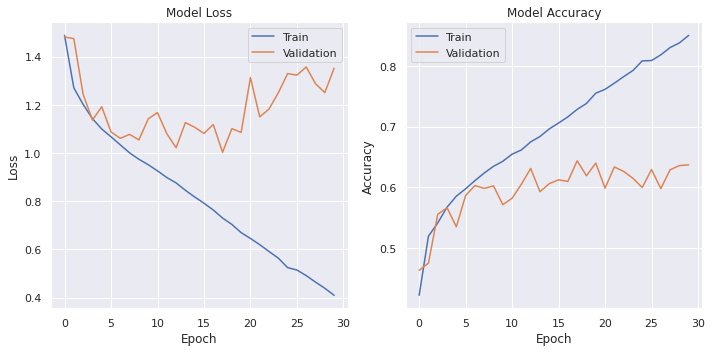

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 15s 72ms/step - loss: 0.9822 - accuracy: 0.6485
Model loss: 0.9822131395339966
Model accuracy 0.6485387086868286


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

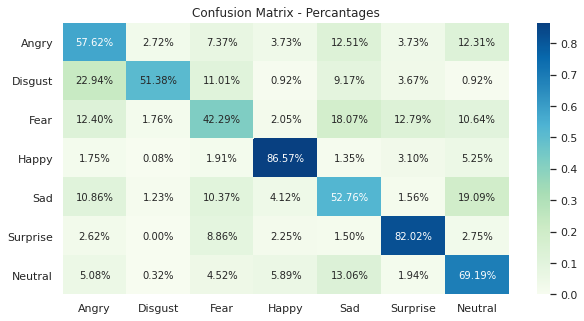

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a little difficulty classifying Angry, Disgust, Fear and Sad.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning + Fine Tuning using Xception",
               "Data with disgust class"] = model_eval[1]

#### ***Model 3 - Transfer Learning using ResNet152V2***


We will create a deep neural network model to predict for each image its label  using transfer learning with a pre-trained ResNet152V2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because ResNet152V2 model expects rgb images.
- Use ResNet152V2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.resnet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.resnet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- ResNet152V2 without its top layers (classification layers)
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.ResNet152V2(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

234553344/234545216 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_2 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_____________________________________________________

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
664/664 [==============================] - 78s 101ms/step - loss: 2.0778 - accuracy: 0.2390 - val_loss: 1.7253 - val_accuracy: 0.3056
Epoch 2/30
664/664 [==============================] - 63s 94ms/step - loss: 1.7474 - accuracy: 0.2844 - val_loss: 1.6692 - val_accuracy: 0.3365
Epoch 3/30
664/664 [==============================] - 63s 94ms/step - loss: 1.7185 - accuracy: 0.3019 - val_loss: 1.6877 - val_accuracy: 0.3346
Epoch 4/30
664/664 [==============================] - 63s 94ms/step - loss: 1.7119 - accuracy: 0.3099 - val_loss: 1.6555 - val_accuracy: 0.3525
Epoch 5/30
664/664 [==============================] - 63s 94ms/step - loss: 1.6957 - accuracy: 0.3174 - val_loss: 1.6277 - val_accuracy: 0.3668
Epoch 6/30
664/664 [==============================] - 63s 94ms/step - loss: 1.6865 - accuracy: 0.3287 - val_loss: 1.6417 - val_accuracy: 0.3497
Epoch 7/30
664/664 [==============================] - 63s 94ms/step - loss: 1.6893 - accuracy: 0.3172 - val_loss: 1.6275 - val_accuracy

Now, let's visualize our model performance:

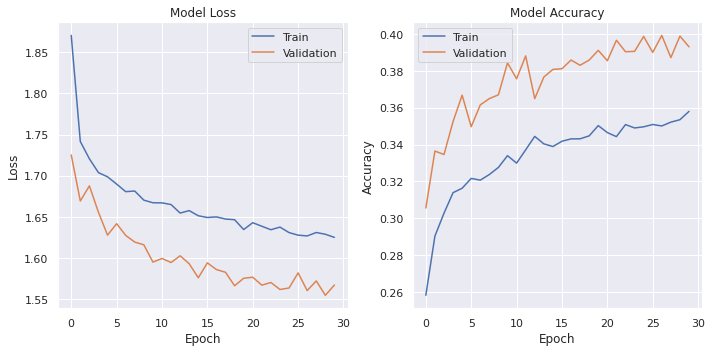

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 16s 78ms/step - loss: 1.5852 - accuracy: 0.3798
Model loss: 1.5852104425430298
Model accuracy 0.3797830641269684


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

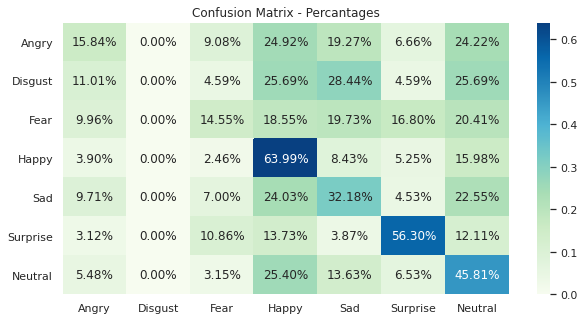

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry, Disgust and Fear and also a little difficulty classifying Sad and Neutral.


Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning using ResNet152V2",
               "Data with disgust class"] = model_eval[1]

#### ***Model 4 - Transfer Learning + Fine Tuning using ResNet152V2***


We will create a deep neural network model to predict for each image its label  using transfer learning and fine tuning with a pre-trained ResNet152V2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because ResNet152V2 model expects rgb images.
- Use ResNet152V2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.resnet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.resnet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- ResNet152V2 without its top layers (classification layers) - with trainable layers to allow fine tuning.
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.ResNet152V2(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = True

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_3 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)              

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
664/664 [==============================] - 236s 325ms/step - loss: 1.8721 - accuracy: 0.2170 - val_loss: 1.9735 - val_accuracy: 0.2122
Epoch 2/30
664/664 [==============================] - 211s 319ms/step - loss: 1.8203 - accuracy: 0.2353 - val_loss: 1.7635 - val_accuracy: 0.3026
Epoch 3/30
664/664 [==============================] - 212s 320ms/step - loss: 1.7080 - accuracy: 0.3044 - val_loss: 1.6508 - val_accuracy: 0.3449
Epoch 4/30
664/664 [==============================] - 212s 319ms/step - loss: 1.6110 - accuracy: 0.3617 - val_loss: 1.5302 - val_accuracy: 0.3963
Epoch 5/30
664/664 [==============================] - 213s 320ms/step - loss: 1.5465 - accuracy: 0.3922 - val_loss: 1.4922 - val_accuracy: 0.4248
Epoch 6/30
664/664 [==============================] - 212s 319ms/step - loss: 1.5000 - accuracy: 0.4196 - val_loss: 1.5483 - val_accuracy: 0.4248
Epoch 7/30
664/664 [==============================] - 212s 320ms/step - loss: 1.4757 - accuracy: 0.4316 - val_loss: 1.4710 -

Now, let's visualize our model performance:

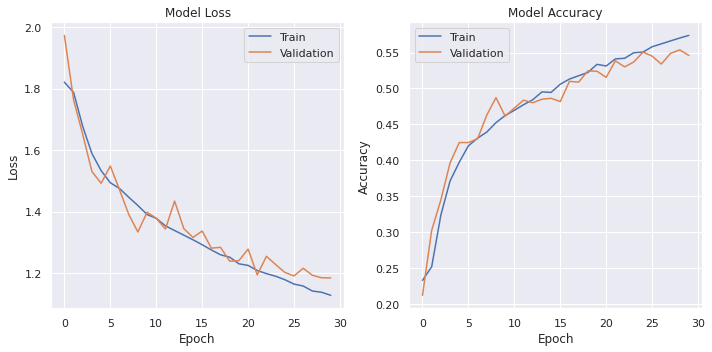

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 16s 76ms/step - loss: 1.1783 - accuracy: 0.5551
Model loss: 1.1782586574554443
Model accuracy 0.5551370978355408


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

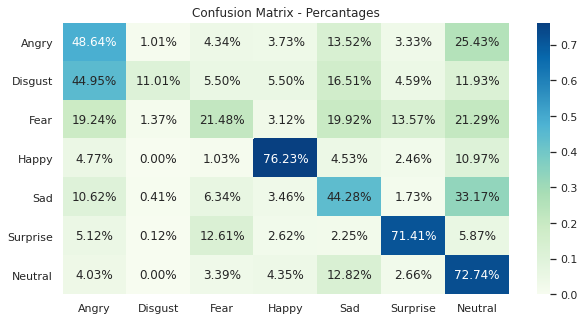

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Disgust and also a little difficulty classifying Angry, and Sad.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning + Fine Tuning using ResNet152V2",
               "Data with disgust class"] = model_eval[1]

#### ***Model 5 - Transfer Learning using MobileNetV2***


We will create a deep neural network model to predict for each image its label  using transfer learning with a pre-trained MobileNetV2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because MobileNetV2 model expects rgb images.
- Use MobileNetV2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.mobilenet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.mobilenet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- MobileNetV2 without its top layers (classification layers)
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.MobileNetV2(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_4 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
664/664 [==============================] - 18s 21ms/step - loss: 1.8282 - accuracy: 0.2697 - val_loss: 1.6425 - val_accuracy: 0.3449
Epoch 2/30
664/664 [==============================] - 12s 19ms/step - loss: 1.6858 - accuracy: 0.3205 - val_loss: 1.6349 - val_accuracy: 0.3485
Epoch 3/30
664/664 [==============================] - 12s 19ms/step - loss: 1.6658 - accuracy: 0.3334 - val_loss: 1.5928 - val_accuracy: 0.3658
Epoch 4/30
664/664 [==============================] - 12s 18ms/step - loss: 1.6425 - accuracy: 0.3429 - val_loss: 1.5939 - val_accuracy: 0.3677
Epoch 5/30
664/664 [==============================] - 12s 19ms/step - loss: 1.6364 - accuracy: 0.3518 - val_loss: 1.5903 - val_accuracy: 0.3747
Epoch 6/30
664/664 [==============================] - 12s 18ms/step - loss: 1.6319 - accuracy: 0.3459 - val_loss: 1.6427 - val_accuracy: 0.3406
Epoch 7/30
664/664 [==============================] - 12s 19ms/step - loss: 1.6305 - accuracy: 0.3417 - val_loss: 1.5809 - val_accuracy:

Now, let's visualize our model performance:

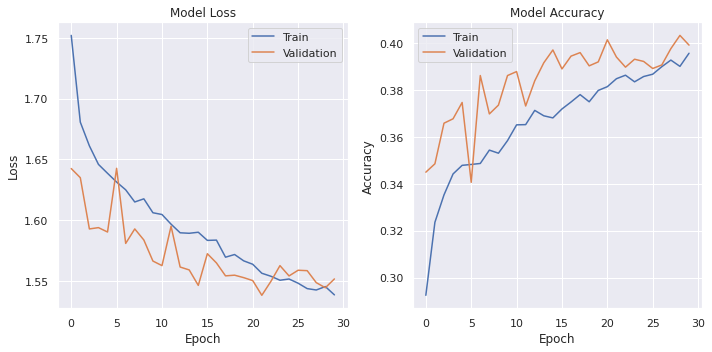

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 3s 15ms/step - loss: 1.5520 - accuracy: 0.4013
Model loss: 1.552003026008606
Model accuracy 0.40132570266723633


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

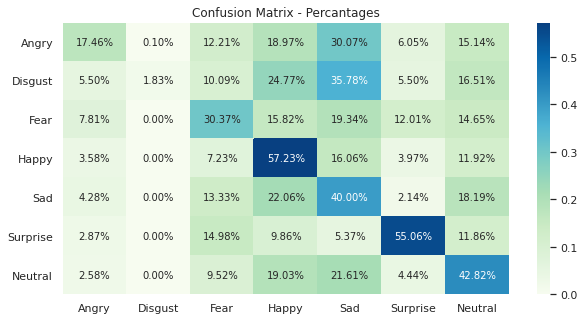

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry and Disgust and also a little difficulty classifying Fear, Happy, Sad, Surprise, Neutral.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning using MobileNetV2",
               "Data with disgust class"] = model_eval[1]

#### ***Model 6 - Transfer Learning + Fine Tuning using MobileNetV2***


We will create a deep neural network model to predict for each image its label  using transfer learning  and fine tuning with a pre-trained MobileNetV2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because MobileNetV2 model expects rgb images.
- Use MobileNetV2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.mobilenet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.mobilenet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- MobileNetV2 without its top layers (classification layers)  - with trainable layers to allow fine tuning.
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.MobileNetV2(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = True

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_5 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)              

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
664/664 [==============================] - 38s 46ms/step - loss: 1.8965 - accuracy: 0.2297 - val_loss: 2.8809 - val_accuracy: 0.2453
Epoch 2/30
664/664 [==============================] - 29s 44ms/step - loss: 1.6258 - accuracy: 0.3597 - val_loss: 2.5989 - val_accuracy: 0.2024
Epoch 3/30
664/664 [==============================] - 29s 44ms/step - loss: 1.5680 - accuracy: 0.3912 - val_loss: 2.9907 - val_accuracy: 0.1796
Epoch 4/30
664/664 [==============================] - 29s 44ms/step - loss: 1.5096 - accuracy: 0.4138 - val_loss: 2.6866 - val_accuracy: 0.2369
Epoch 5/30
664/664 [==============================] - 29s 44ms/step - loss: 1.5177 - accuracy: 0.4075 - val_loss: 2.6453 - val_accuracy: 0.2760
Epoch 6/30
664/664 [==============================] - 29s 44ms/step - loss: 1.4902 - accuracy: 0.4209 - val_loss: 2.7937 - val_accuracy: 0.2694
Epoch 7/30
664/664 [==============================] - 29s 44ms/step - loss: 1.5284 - accuracy: 0.4083 - val_loss: 2.8210 - val_accuracy:

Now, let's visualize our model performance:

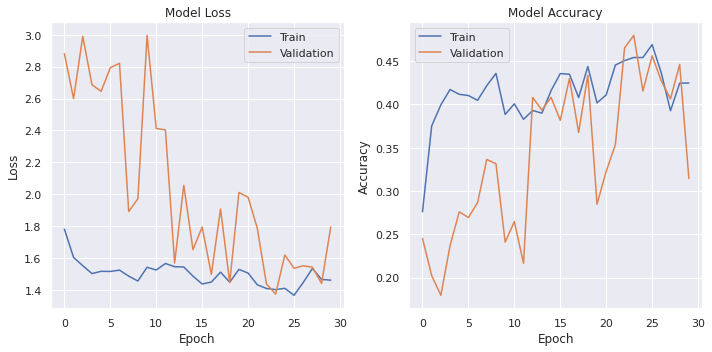

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 3s 14ms/step - loss: 1.3627 - accuracy: 0.4771
Model loss: 1.3626872301101685
Model accuracy 0.47710153460502625


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

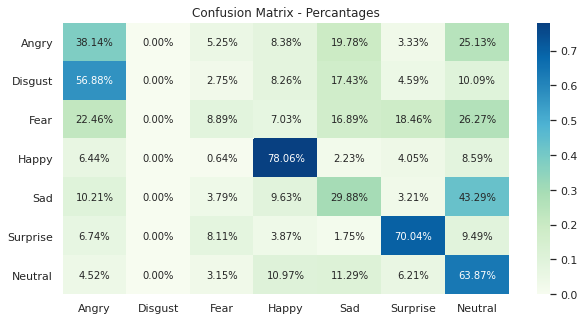

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Disgust, Fear and Sad and also a little difficulty classifying Angry.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning + Fine Tuning using MobileNetV2",
               "Data with disgust class"] = model_eval[1]

#### ***Model 7 - Transfer Learning using EfficientNetB0***


We will create a deep neural network model to predict for each image its label  using transfer learning with a pre-trained EfficientNetB0 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because EfficientNetB0 model expects rgb images.
- Use EfficientNetB0 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.efficientnet.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.efficientnet.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- EfficientNetB0 without its top layers (classification layers)
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.EfficientNetB0(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_6 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_6 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_14 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_______________________________________________________

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
664/664 [==============================] - 29s 32ms/step - loss: 1.7683 - accuracy: 0.2774 - val_loss: 1.6155 - val_accuracy: 0.3764
Epoch 2/30
664/664 [==============================] - 19s 28ms/step - loss: 1.6762 - accuracy: 0.3258 - val_loss: 1.5875 - val_accuracy: 0.3871
Epoch 3/30
664/664 [==============================] - 19s 28ms/step - loss: 1.6530 - accuracy: 0.3401 - val_loss: 1.5771 - val_accuracy: 0.3832
Epoch 4/30
664/664 [==============================] - 19s 28ms/step - loss: 1.6490 - accuracy: 0.3439 - val_loss: 1.5471 - val_accuracy: 0.3956
Epoch 5/30
664/664 [==============================] - 19s 28ms/step - loss: 1.6362 - accuracy: 0.3483 - val_loss: 1.5704 - val_accuracy: 0.3954
Epoch 6/30
664/664 [==============================] - 19s 28ms/step - loss: 1.6313 - accuracy: 0.3506 - val_loss: 1.5388 - val_accuracy: 0.3988
Epoch 7/30
664/664 [==============================] - 19s 28ms/step - loss: 1.6194 - accuracy: 0.3553 - val_loss: 1.5439 - val_accuracy:

Now, let's visualize our model performance:

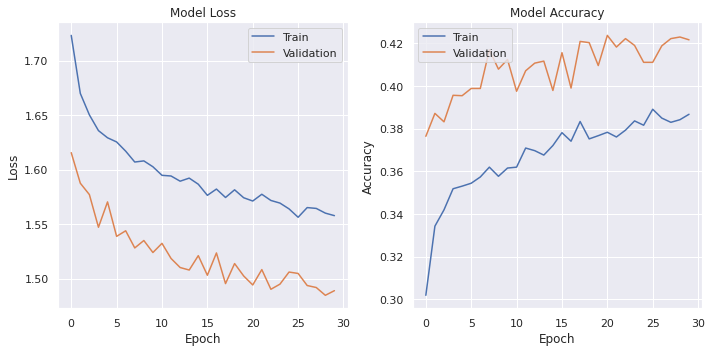

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 5s 23ms/step - loss: 1.5131 - accuracy: 0.4084
Model loss: 1.513105034828186
Model accuracy 0.408406138420105


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

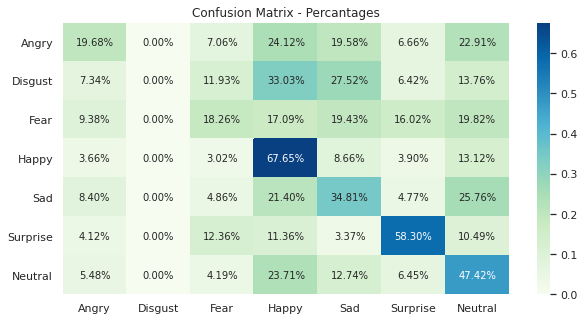

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry, Disgust and Fear and also a little difficulty classifying Sad and Neutral.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning using EfficientNetB0",
               "Data with disgust class"] = model_eval[1]

#### ***Model 8 - Transfer Learning + Fine Tuning using EfficientNetB0***


We will create a deep neural network model to predict for each image its label  using transfer learning  and fine tuning with a pre-trained EfficientNetB0 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because EfficientNetB0 model expects rgb images.
- Use EfficientNetB0 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.efficientnet.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.efficientnet.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- EfficientNetB0 without its top layers (classification layers)  - with trainable layers to allow fine tuning.
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.EfficientNetB0(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = True

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 48, 48, 3)         0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
664/664 [==============================] - 81s 63ms/step - loss: 1.7397 - accuracy: 0.3055 - val_loss: 1.5009 - val_accuracy: 0.4223
Epoch 2/30
664/664 [==============================] - 39s 59ms/step - loss: 1.4846 - accuracy: 0.4381 - val_loss: 1.3806 - val_accuracy: 0.4790
Epoch 3/30
664/664 [==============================] - 39s 59ms/step - loss: 1.3953 - accuracy: 0.4648 - val_loss: 1.2897 - val_accuracy: 0.4990
Epoch 4/30
664/664 [==============================] - 39s 59ms/step - loss: 1.3250 - accuracy: 0.4950 - val_loss: 1.2769 - val_accuracy: 0.5204
Epoch 5/30
664/664 [==============================] - 39s 58ms/step - loss: 1.3045 - accuracy: 0.5017 - val_loss: 1.2304 - val_accuracy: 0.5236
Epoch 6/30
664/664 [==============================] - 39s 59ms/step - loss: 1.2703 - accuracy: 0.5185 - val_loss: 1.2200 - val_accuracy: 0.5368
Epoch 7/30
664/664 [==============================] - 39s 58ms/step - loss: 1.2477 - accuracy: 0.5294 - val_loss: 1.2155 - val_accuracy:

Now, let's visualize our model performance:

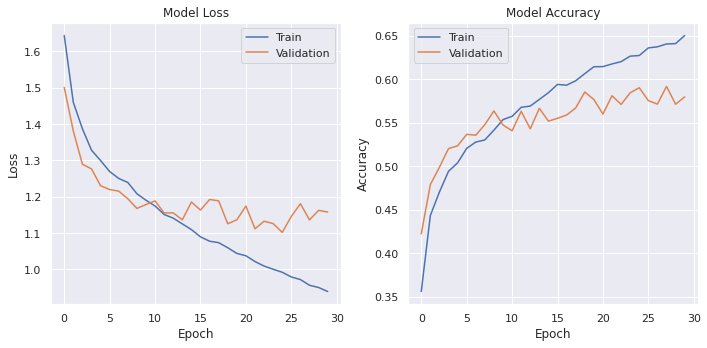

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 3s 15ms/step - loss: 1.1401 - accuracy: 0.5856
Model loss: 1.1401054859161377
Model accuracy 0.5855679512023926


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

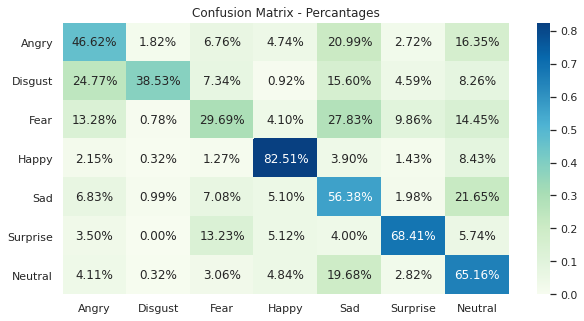

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Fear and also a little difficulty classifying Angry and Disgust.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning + Fine Tuning using EfficientNetB0",
               "Data with disgust class"] = model_eval[1]

#### ***Model 9 - Transfer Learning using InceptionResNetV2***


We will create a deep neural network model to predict for each image its label  using transfer learning with a pre-trained InceptionResNetV2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 96 x 96 x 3 because Xception model expects rgb images bigger than 75 x 75.
- Use InceptionResNetV2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)
# resize images and change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.inception_resnet_v2.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.inception_resnet_v2.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 96 X 96 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- InceptionResNetV2 without its top layers (classification layers)
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.InceptionResNetV2(
    weights='imagenet', input_shape=(96, 96, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(96, 96, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_8 (RandomFlip)   (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation_8 (RandomRot (None, 96, 96, 3)         0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_20 (Dense)             (None, 512)               786944    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_____________________________________________________

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
664/664 [==============================] - 109s 143ms/step - loss: 1.9408 - accuracy: 0.2416 - val_loss: 1.6782 - val_accuracy: 0.3295
Epoch 2/30
664/664 [==============================] - 90s 135ms/step - loss: 1.7311 - accuracy: 0.3003 - val_loss: 1.6573 - val_accuracy: 0.3271
Epoch 3/30
664/664 [==============================] - 90s 135ms/step - loss: 1.6930 - accuracy: 0.3172 - val_loss: 1.6134 - val_accuracy: 0.3760
Epoch 4/30
664/664 [==============================] - 90s 135ms/step - loss: 1.6791 - accuracy: 0.3316 - val_loss: 1.6190 - val_accuracy: 0.3666
Epoch 5/30
664/664 [==============================] - 90s 135ms/step - loss: 1.6611 - accuracy: 0.3399 - val_loss: 1.5795 - val_accuracy: 0.3931
Epoch 6/30
664/664 [==============================] - 90s 135ms/step - loss: 1.6468 - accuracy: 0.3469 - val_loss: 1.6013 - val_accuracy: 0.3790
Epoch 7/30
664/664 [==============================] - 90s 135ms/step - loss: 1.6462 - accuracy: 0.3481 - val_loss: 1.5839 - val_a

Now, let's visualize our model performance:

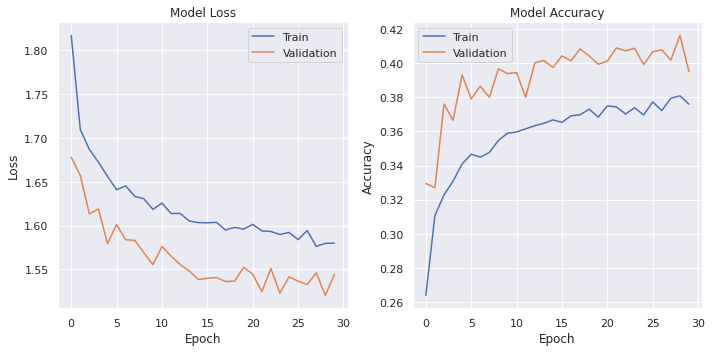

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 23s 111ms/step - loss: 1.5257 - accuracy: 0.4153
Model loss: 1.5256932973861694
Model accuracy 0.4153359532356262


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

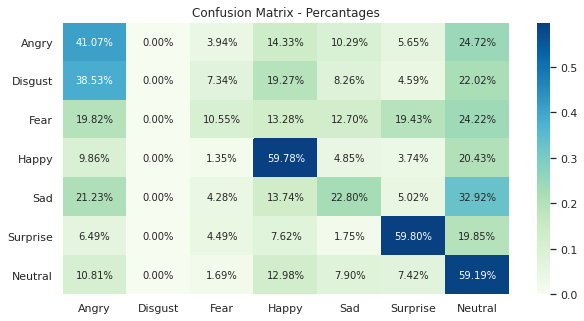

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Disgust, Fear and Sad and also a little difficulty classifying Angry.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning using InceptionResNetV2",
               "Data with disgust class"] = model_eval[1]

#### ***Model 10 - Transfer Learning + Fine Tuning using InceptionResNetV2***


We will create a deep neural network model to predict for each image its label  using transfer learning and fine tuning with a pre-trained InceptionResNetV2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 96 x 96 x 3 because Xception model expects rgb images bigger than 75 x 75.
- Use InceptionResNetV2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)
# resize images and change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.inception_resnet_v2.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.inception_resnet_v2.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 96 X 96 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- InceptionResNetV2 without its top layers (classification layers) - with trainable layers to allow fine tuning.
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.InceptionResNetV2(
    weights='imagenet', input_shape=(96, 96, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(96, 96, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_9 (RandomFlip)   (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation_9 (RandomRot (None, 96, 96, 3)         0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_23 (Dense)             (None, 512)               786944    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)              

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
664/664 [==============================] - 107s 142ms/step - loss: 1.9123 - accuracy: 0.2434 - val_loss: 1.6851 - val_accuracy: 0.3159
Epoch 2/30
664/664 [==============================] - 90s 135ms/step - loss: 1.7202 - accuracy: 0.3033 - val_loss: 1.6254 - val_accuracy: 0.3474
Epoch 3/30
664/664 [==============================] - 90s 135ms/step - loss: 1.6840 - accuracy: 0.3226 - val_loss: 1.6142 - val_accuracy: 0.3628
Epoch 4/30
664/664 [==============================] - 90s 135ms/step - loss: 1.6589 - accuracy: 0.3346 - val_loss: 1.6098 - val_accuracy: 0.3600
Epoch 5/30
664/664 [==============================] - 90s 135ms/step - loss: 1.6551 - accuracy: 0.3420 - val_loss: 1.5902 - val_accuracy: 0.3849
Epoch 6/30
664/664 [==============================] - 90s 135ms/step - loss: 1.6367 - accuracy: 0.3543 - val_loss: 1.5890 - val_accuracy: 0.3818
Epoch 7/30
664/664 [==============================] - 90s 135ms/step - loss: 1.6346 - accuracy: 0.3472 - val_loss: 1.5818 - val_a

Now, let's visualize our model performance:

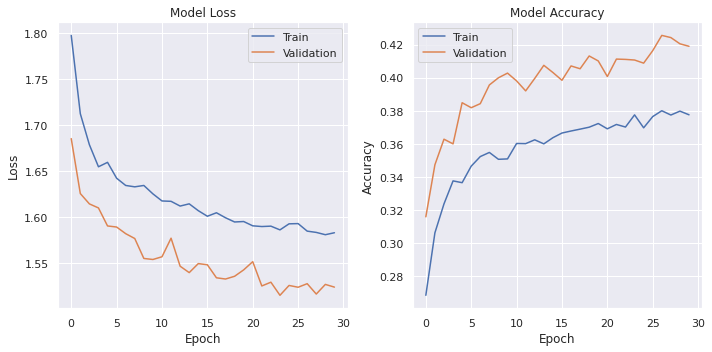

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 23s 108ms/step - loss: 1.5326 - accuracy: 0.4138
Model loss: 1.5325771570205688
Model accuracy 0.4138294756412506


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

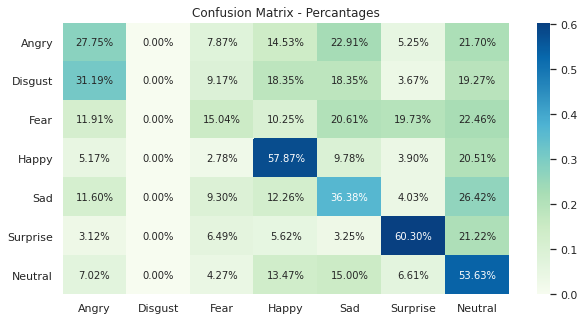

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry, Disgust and Fear and also a little difficulty classifying Sad.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning + Fine Tuning using InceptionResNetV2",
               "Data with disgust class"] = model_eval[1]

#### ***Model 11 - Self Made CNN***

Because all pre trained model expect and rgb image We will create a simple deep neural network model that expects a 2-d image to predict for each image its label.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- expand image dimension to 48 X 48 X 1 - in order to have 3 dimensions.
- normalize images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)

# normalize images
x_train: np.ndarray = images_train / 255.0
x_test: np.ndarray = images_test / 255.0

# expand image dimension
x_train: np.ndarray = x_train.reshape(x_train.shape + (1,))
x_test: np.ndarray = x_test.reshape(x_test.shape + (1,))

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the a cnn model to predict our image labels:

In [ ]:
# create new model
model: keras.Model = keras.models.Sequential(
    [
     # Block 1
     keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                         padding='same', input_shape=(48,48, 1)),
     keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                         padding='same'),
     keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     keras.layers.BatchNormalization(),

     # Block 2
     keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                         padding='same'),
     keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                         padding='same'),
     keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     keras.layers.BatchNormalization(),

     # Block 3
     keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',
                         padding='same'),
     keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',
                         padding='same'),
     keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     keras.layers.BatchNormalization(),

     # Flattens the input for FC
     keras.layers.Flatten(),

     # fully connected layers
     keras.layers.Dense(750, activation='relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(850, activation='relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(850, activation='relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(750, activation='relu'),
     keras.layers.Dropout(0.5),

     # classification layer
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_414 (Conv2D)          (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_415 (Conv2D)          (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_414 (Bat (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_416 (Conv2D)          (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_417 (Conv2D)          (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 64)      

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=50, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
664/664 [==============================] - 20s 27ms/step - loss: 2.1311 - accuracy: 0.1859 - val_loss: 1.7699 - val_accuracy: 0.2416
Epoch 2/50
664/664 [==============================] - 18s 26ms/step - loss: 1.7971 - accuracy: 0.2345 - val_loss: 1.7176 - val_accuracy: 0.2843
Epoch 3/50
664/664 [==============================] - 17s 26ms/step - loss: 1.7064 - accuracy: 0.3000 - val_loss: 1.6511 - val_accuracy: 0.3429
Epoch 4/50
664/664 [==============================] - 18s 27ms/step - loss: 1.5835 - accuracy: 0.3671 - val_loss: 1.6205 - val_accuracy: 0.3677
Epoch 5/50
664/664 [==============================] - 17s 26ms/step - loss: 1.5094 - accuracy: 0.4112 - val_loss: 1.4293 - val_accuracy: 0.4577
Epoch 6/50
664/664 [==============================] - 18s 26ms/step - loss: 1.4368 - accuracy: 0.4399 - val_loss: 1.5138 - val_accuracy: 0.4140
Epoch 7/50
664/664 [==============================] - 17s 26ms/step - loss: 1.3868 - accuracy: 0.4601 - val_loss: 1.4131 - val_accuracy:

Now, let's visualize our model performance:

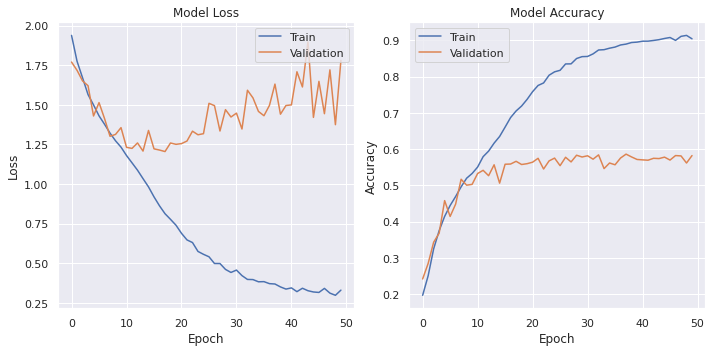

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 2s 9ms/step - loss: 1.6679 - accuracy: 0.5857
Model loss: 1.6678889989852905
Model accuracy 0.58571857213974


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

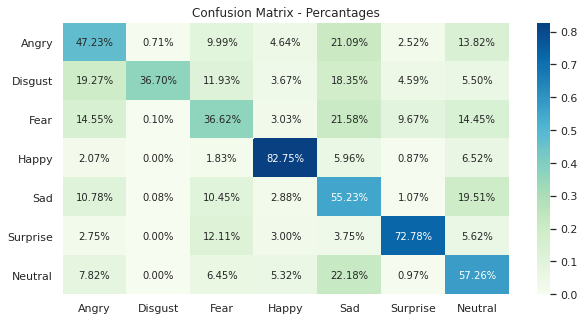

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a little difficulty classifying Angry, Disgust and Fear.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Self Made CNN", "Data with disgust class"] = model_eval[1]

### ***Data Excludes Disgust Class***

Next, let's build models with 6 classes (without disgust).

#### ***Model 1 - Transfer Learning using Xception***


We will create a deep neural network model to predict for each image its label  using transfer learning with a pre-trained Xception model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 96 x 96 x 3 because Xception model expects rgb images bigger than 71 x 71.
- Use Xception preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images_without_disgust, labels_without_disgust, test_size=0.20,
    random_state=42, stratify=labels_without_disgust)

# resize images and change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.xception.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.xception.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 6)
y_test = keras.utils.to_categorical(labels_test, 6)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 96 X 96 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- Xception without its top layers (classification layers)
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.Xception(
    weights='imagenet', input_shape=(96, 96, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(96, 96, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dropout(0.3),
     # classification layer
     keras.layers.Dense(6, activation='softmax')
    ]
)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_10 (RandomFlip)  (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation_10 (RandomRo (None, 96, 96, 3)         0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout_22 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 12294     
Total params: 20,873,774
Trainable params: 12,294
Non-trainable params: 20,861,480
_________________________________________________________________


Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
653/653 [==============================] - 66s 95ms/step - loss: 1.7557 - accuracy: 0.2859 - val_loss: 1.5529 - val_accuracy: 0.3843
Epoch 2/30
653/653 [==============================] - 60s 92ms/step - loss: 1.6421 - accuracy: 0.3425 - val_loss: 1.5415 - val_accuracy: 0.3910
Epoch 3/30
653/653 [==============================] - 60s 91ms/step - loss: 1.6175 - accuracy: 0.3497 - val_loss: 1.5108 - val_accuracy: 0.4042
Epoch 4/30
653/653 [==============================] - 60s 92ms/step - loss: 1.5999 - accuracy: 0.3678 - val_loss: 1.5021 - val_accuracy: 0.4013
Epoch 5/30
653/653 [==============================] - 60s 91ms/step - loss: 1.5934 - accuracy: 0.3736 - val_loss: 1.5471 - val_accuracy: 0.3892
Epoch 6/30
653/653 [==============================] - 60s 91ms/step - loss: 1.5935 - accuracy: 0.3633 - val_loss: 1.4900 - val_accuracy: 0.4049
Epoch 7/30
653/653 [==============================] - 60s 91ms/step - loss: 1.5991 - accuracy: 0.3674 - val_loss: 1.5003 - val_accuracy:

Now, let's visualize our model performance:

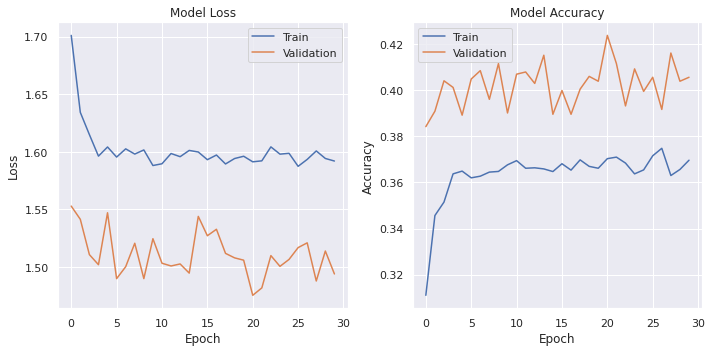

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

205/205 [==============================] - 15s 74ms/step - loss: 1.4869 - accuracy: 0.4149
Model loss: 1.4869370460510254
Model accuracy 0.41491806507110596


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

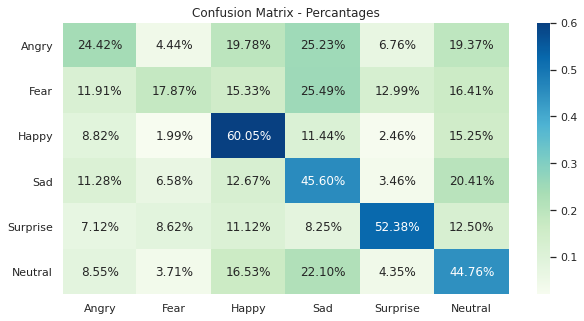

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry and Fear and also a little difficulty classifying Sad and Neutral.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning using Xception",
               "Data without disgust class"] = model_eval[1]

#### ***Model 2 - Transfer Learning + Fine Tuning using Xception***


We will create a deep neural network model to predict for each image its label  using transfer learning and Fine tuning with a pre-trained Xception model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 96 x 96 x 3 because Xception model expects rgb images bigger than 71 x 71.
- Use Xception preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images_without_disgust, labels_without_disgust, test_size=0.20,
    random_state=42, stratify=labels_without_disgust)
# resize images and change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.xception.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.xception.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 6)
y_test = keras.utils.to_categorical(labels_test, 6)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 96 X 96 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- Xception without its top layers (classification layers) - with trainable layers to allow fine tuning.
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.Xception(
    weights='imagenet', input_shape=(96, 96, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = True

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(96, 96, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dropout(0.3),
     # classification layer
     keras.layers.Dense(6, activation='softmax')
    ]
)
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_11 (RandomFlip)  (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation_11 (RandomRo (None, 96, 96, 3)         0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout_23 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 12294     
Total params: 20,873,774
Trainable params: 20,819,246
Non-trainable params: 54,528
_________________________________________________________________


Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
653/653 [==============================] - 198s 293ms/step - loss: 1.6852 - accuracy: 0.2802 - val_loss: 1.3217 - val_accuracy: 0.4834
Epoch 2/30
653/653 [==============================] - 190s 290ms/step - loss: 1.3049 - accuracy: 0.4760 - val_loss: 1.4123 - val_accuracy: 0.5020
Epoch 3/30
653/653 [==============================] - 190s 291ms/step - loss: 1.1840 - accuracy: 0.5329 - val_loss: 1.1777 - val_accuracy: 0.5485
Epoch 4/30
653/653 [==============================] - 190s 291ms/step - loss: 1.1206 - accuracy: 0.5656 - val_loss: 1.1615 - val_accuracy: 0.5495
Epoch 5/30
653/653 [==============================] - 190s 291ms/step - loss: 1.0737 - accuracy: 0.5874 - val_loss: 1.1420 - val_accuracy: 0.5667
Epoch 6/30
653/653 [==============================] - 190s 291ms/step - loss: 1.0227 - accuracy: 0.6067 - val_loss: 3.1327 - val_accuracy: 0.5370
Epoch 7/30
653/653 [==============================] - 190s 291ms/step - loss: 0.9956 - accuracy: 0.6158 - val_loss: 1.0461 -

Now, let's visualize our model performance:

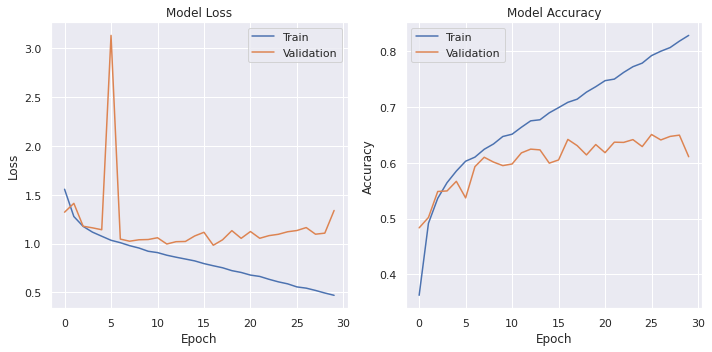

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

205/205 [==============================] - 15s 72ms/step - loss: 1.1302 - accuracy: 0.6517
Model loss: 1.1301801204681396
Model accuracy 0.6517077684402466


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

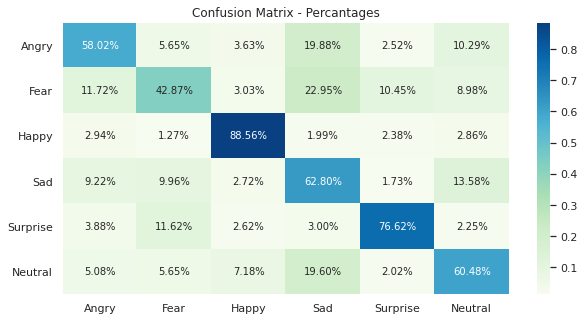

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a little difficulty classifying Fear.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning + Fine Tuning using Xception",
               "Data without disgust class"] = model_eval[1]

#### ***Model 3 - Transfer Learning using ResNet152V2***


We will create a deep neural network model to predict for each image its label  using transfer learning with a pre-trained ResNet152V2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because ResNet152V2 model expects rgb images.
- Use ResNet152V2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images_without_disgust, labels_without_disgust, test_size=0.20,
    random_state=42, stratify=labels_without_disgust)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.resnet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.resnet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 6)
y_test = keras.utils.to_categorical(labels_test, 6)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- ResNet152V2 without its top layers (classification layers)
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.ResNet152V2(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(6, activation='softmax')
    ]
)
model.summary()

234553344/234545216 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_____________________________________________________

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
653/653 [==============================] - 52s 66ms/step - loss: 2.0274 - accuracy: 0.2400 - val_loss: 1.6493 - val_accuracy: 0.3197
Epoch 2/30
653/653 [==============================] - 40s 61ms/step - loss: 1.6837 - accuracy: 0.2945 - val_loss: 1.6350 - val_accuracy: 0.3343
Epoch 3/30
653/653 [==============================] - 40s 61ms/step - loss: 1.6550 - accuracy: 0.3154 - val_loss: 1.5982 - val_accuracy: 0.3527
Epoch 4/30
653/653 [==============================] - 40s 61ms/step - loss: 1.6438 - accuracy: 0.3211 - val_loss: 1.5959 - val_accuracy: 0.3693
Epoch 5/30
653/653 [==============================] - 40s 61ms/step - loss: 1.6296 - accuracy: 0.3308 - val_loss: 1.5684 - val_accuracy: 0.3699
Epoch 6/30
653/653 [==============================] - 40s 61ms/step - loss: 1.6270 - accuracy: 0.3333 - val_loss: 1.5698 - val_accuracy: 0.3733
Epoch 7/30
653/653 [==============================] - 40s 61ms/step - loss: 1.6229 - accuracy: 0.3334 - val_loss: 1.5615 - val_accuracy:

Now, let's visualize our model performance:

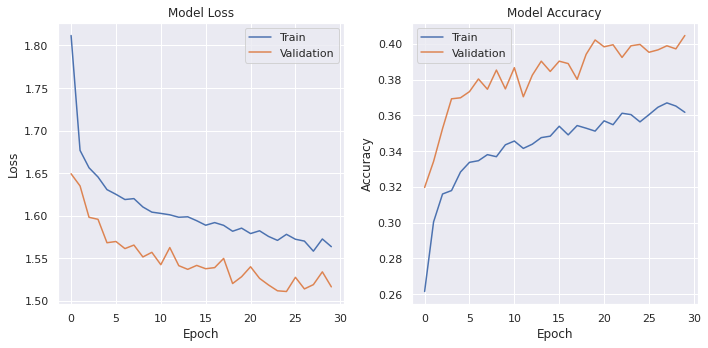

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

205/205 [==============================] - 10s 49ms/step - loss: 1.5318 - accuracy: 0.3898
Model loss: 1.5318080186843872
Model accuracy 0.3897993564605713


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

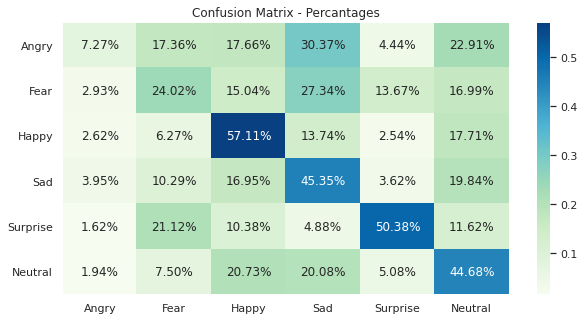

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry and Fear and also a little difficulty classifying Sad and Neutral.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning using ResNet152V2",
               "Data without disgust class"] = model_eval[1]

#### ***Model 4 - Transfer Learning + Fine Tuning using ResNet152V2***


We will create a deep neural network model to predict for each image its label  using transfer learning and fine tuning with a pre-trained ResNet152V2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because ResNet152V2 model expects rgb images.
- Use ResNet152V2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images_without_disgust, labels_without_disgust, test_size=0.20,
    random_state=42, stratify=labels_without_disgust)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.resnet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.resnet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 6)
y_test = keras.utils.to_categorical(labels_test, 6)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- ResNet152V2 without its top layers (classification layers) - with trainable layers to allow fine tuning.
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.ResNet152V2(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = True

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(6, activation='softmax')
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_2 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)              

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
653/653 [==============================] - 133s 180ms/step - loss: 1.8698 - accuracy: 0.1886 - val_loss: 1.7845 - val_accuracy: 0.1995
Epoch 2/30
653/653 [==============================] - 114s 175ms/step - loss: 1.7828 - accuracy: 0.1945 - val_loss: 1.7878 - val_accuracy: 0.1978
Epoch 3/30
653/653 [==============================] - 114s 175ms/step - loss: 1.7811 - accuracy: 0.1912 - val_loss: 1.7827 - val_accuracy: 0.1848
Epoch 4/30
653/653 [==============================] - 114s 175ms/step - loss: 1.7812 - accuracy: 0.1913 - val_loss: 1.7760 - val_accuracy: 0.1976
Epoch 5/30
653/653 [==============================] - 114s 175ms/step - loss: 1.7790 - accuracy: 0.1941 - val_loss: 2111343616.0000 - val_accuracy: 0.1842
Epoch 6/30
653/653 [==============================] - 114s 175ms/step - loss: 1.7890 - accuracy: 0.1894 - val_loss: 1.7582 - val_accuracy: 0.2133
Epoch 7/30
653/653 [==============================] - 115s 176ms/step - loss: 1.7663 - accuracy: 0.2156 - val_loss:

Now, let's visualize our model performance:

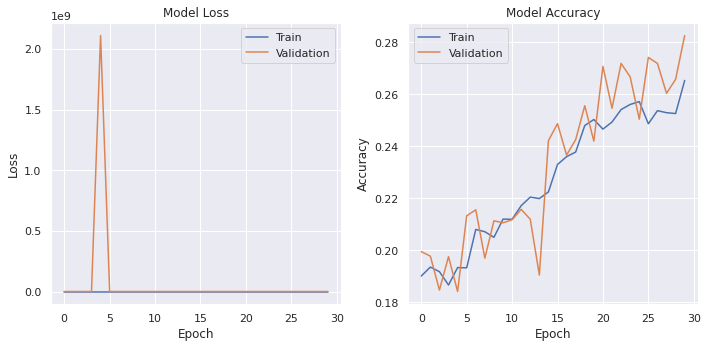

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

205/205 [==============================] - 9s 46ms/step - loss: 1.6361 - accuracy: 0.2714
Model loss: 1.6360751390457153
Model accuracy 0.271404504776001


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

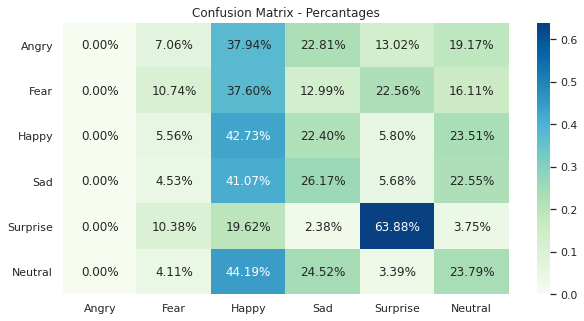

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry, Fear, Sad and Neutral.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning + Fine Tuning using ResNet152V2",
               "Data without disgust class"] = model_eval[1]

#### ***Model 5 - Transfer Learning using MobileNetV2***


We will create a deep neural network model to predict for each image its label  using transfer learning with a pre-trained MobileNetV2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because MobileNetV2 model expects rgb images.
- Use MobileNetV2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images_without_disgust, labels_without_disgust, test_size=0.20,
    random_state=42, stratify=labels_without_disgust)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.mobilenet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.mobilenet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 6)
y_test = keras.utils.to_categorical(labels_test, 6)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- MobileNetV2 without its top layers (classification layers)
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.MobileNetV2(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(6, activation='softmax')
    ]
)
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_3 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_9 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
653/653 [==============================] - 11s 13ms/step - loss: 1.7560 - accuracy: 0.2811 - val_loss: 1.6004 - val_accuracy: 0.3446
Epoch 2/30
653/653 [==============================] - 8s 12ms/step - loss: 1.6205 - accuracy: 0.3314 - val_loss: 1.5713 - val_accuracy: 0.3686
Epoch 3/30
653/653 [==============================] - 8s 12ms/step - loss: 1.5856 - accuracy: 0.3508 - val_loss: 1.5735 - val_accuracy: 0.3592
Epoch 4/30
653/653 [==============================] - 8s 12ms/step - loss: 1.5860 - accuracy: 0.3543 - val_loss: 1.5700 - val_accuracy: 0.3689
Epoch 5/30
653/653 [==============================] - 8s 12ms/step - loss: 1.5731 - accuracy: 0.3613 - val_loss: 1.5497 - val_accuracy: 0.3737
Epoch 6/30
653/653 [==============================] - 8s 12ms/step - loss: 1.5589 - accuracy: 0.3622 - val_loss: 1.5332 - val_accuracy: 0.3825
Epoch 7/30
653/653 [==============================] - 8s 12ms/step - loss: 1.5581 - accuracy: 0.3681 - val_loss: 1.5250 - val_accuracy: 0.387

Now, let's visualize our model performance:

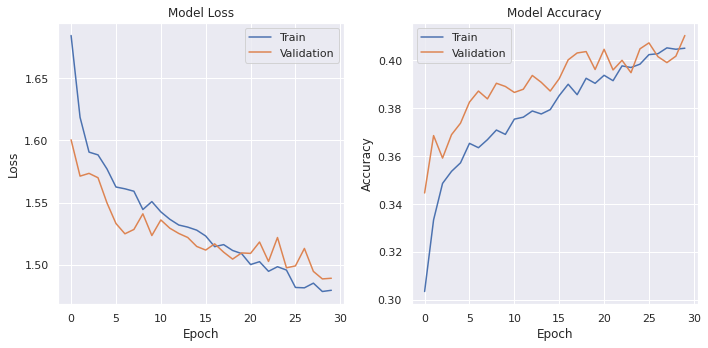

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

205/205 [==============================] - 2s 10ms/step - loss: 1.5118 - accuracy: 0.3941
Model loss: 1.5117697715759277
Model accuracy 0.39408791065216064


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

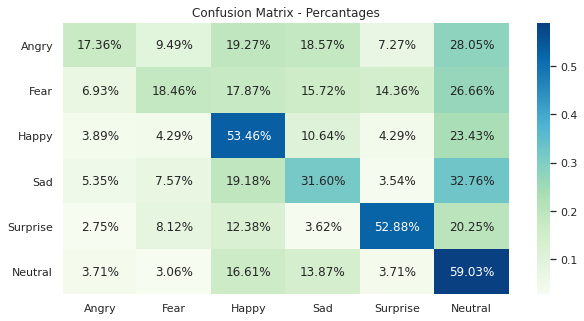

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry, Disgust and Fear and also a little difficulty classifying Sad.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning using MobileNetV2",
               "Data without disgust class"] = model_eval[1]

#### ***Model 6 - Transfer Learning + Fine Tuning using MobileNetV2***


We will create a deep neural network model to predict for each image its label  using transfer learning  and fine tuning with a pre-trained MobileNetV2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because MobileNetV2 model expects rgb images.
- Use MobileNetV2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images_without_disgust, labels_without_disgust, test_size=0.20,
    random_state=42, stratify=labels_without_disgust)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.mobilenet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.mobilenet_v2.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 6)
y_test = keras.utils.to_categorical(labels_test, 6)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- MobileNetV2 without its top layers (classification layers)  - with trainable layers to allow fine tuning.
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.MobileNetV2(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = True

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(6, activation='softmax')
    ]
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_4 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_12 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)              

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
653/653 [==============================] - 25s 31ms/step - loss: 1.7944 - accuracy: 0.2689 - val_loss: 2.3040 - val_accuracy: 0.3207
Epoch 2/30
653/653 [==============================] - 19s 29ms/step - loss: 1.5168 - accuracy: 0.3926 - val_loss: 2.9552 - val_accuracy: 0.3138
Epoch 3/30
653/653 [==============================] - 19s 29ms/step - loss: 1.4309 - accuracy: 0.4317 - val_loss: 3.3633 - val_accuracy: 0.2636
Epoch 4/30
653/653 [==============================] - 19s 29ms/step - loss: 1.3803 - accuracy: 0.4441 - val_loss: 2.4411 - val_accuracy: 0.3666
Epoch 5/30
653/653 [==============================] - 19s 29ms/step - loss: 1.3719 - accuracy: 0.4505 - val_loss: 4.8836 - val_accuracy: 0.2646
Epoch 6/30
653/653 [==============================] - 19s 29ms/step - loss: 1.3724 - accuracy: 0.4609 - val_loss: 2.3908 - val_accuracy: 0.2257
Epoch 7/30
653/653 [==============================] - 19s 29ms/step - loss: 1.3868 - accuracy: 0.4471 - val_loss: 4.2537 - val_accuracy:

Now, let's visualize our model performance:

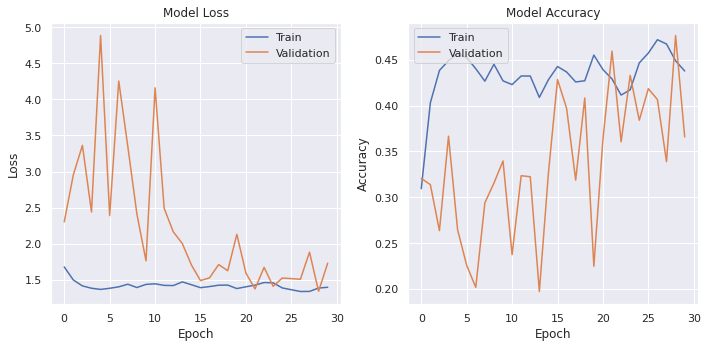

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

205/205 [==============================] - 2s 9ms/step - loss: 1.3659 - accuracy: 0.4675
Model loss: 1.3658701181411743
Model accuracy 0.46745291352272034


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

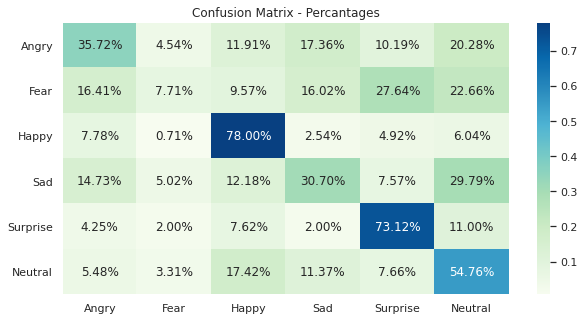

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Fear and also a little difficulty classifying Angry and Sad.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning + Fine Tuning using MobileNetV2",
               "Data without disgust class"] = model_eval[1]

#### ***Model 7 - Transfer Learning using EfficientNetB0***


We will create a deep neural network model to predict for each image its label  using transfer learning with a pre-trained EfficientNetB0 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because EfficientNetB0 model expects rgb images.
- Use EfficientNetB0 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images_without_disgust, labels_without_disgust, test_size=0.20,
    random_state=42, stratify=labels_without_disgust)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.efficientnet.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.efficientnet.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 6)
y_test = keras.utils.to_categorical(labels_test, 6)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- EfficientNetB0 without its top layers (classification layers)
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.EfficientNetB0(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(6, activation='softmax')
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_5 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_15 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)              

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
653/653 [==============================] - 19s 21ms/step - loss: 1.6957 - accuracy: 0.2886 - val_loss: 1.5568 - val_accuracy: 0.3649
Epoch 2/30
653/653 [==============================] - 12s 18ms/step - loss: 1.6146 - accuracy: 0.3344 - val_loss: 1.5363 - val_accuracy: 0.3825
Epoch 3/30
653/653 [==============================] - 12s 18ms/step - loss: 1.5835 - accuracy: 0.3473 - val_loss: 1.5213 - val_accuracy: 0.3917
Epoch 4/30
653/653 [==============================] - 12s 18ms/step - loss: 1.5769 - accuracy: 0.3553 - val_loss: 1.5230 - val_accuracy: 0.3846
Epoch 5/30
653/653 [==============================] - 12s 18ms/step - loss: 1.5598 - accuracy: 0.3588 - val_loss: 1.5135 - val_accuracy: 0.3957
Epoch 6/30
653/653 [==============================] - 12s 18ms/step - loss: 1.5661 - accuracy: 0.3562 - val_loss: 1.4929 - val_accuracy: 0.4034
Epoch 7/30
653/653 [==============================] - 12s 18ms/step - loss: 1.5527 - accuracy: 0.3673 - val_loss: 1.4987 - val_accuracy:

Now, let's visualize our model performance:

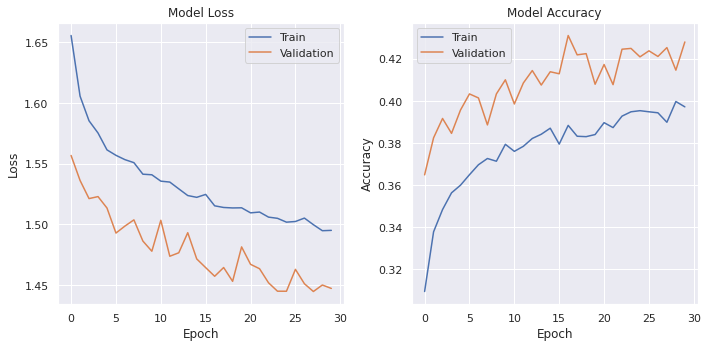

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

205/205 [==============================] - 3s 14ms/step - loss: 1.4700 - accuracy: 0.4122
Model loss: 1.469975471496582
Model accuracy 0.4121611416339874


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

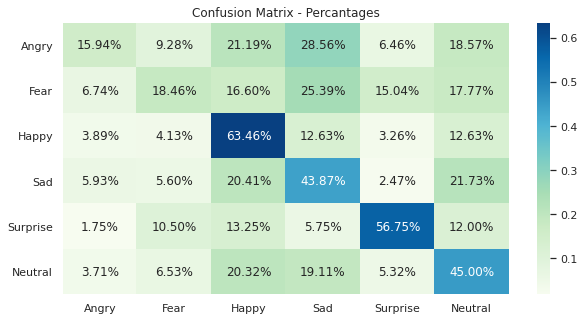

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry and Fear and also a little difficulty classifying Sad and Neutral.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning using EfficientNetB0",
               "Data without disgust class"] = model_eval[1]

#### ***Model 8 - Transfer Learning + Fine Tuning using EfficientNetB0***


We will create a deep neural network model to predict for each image its label  using transfer learning  and fine tuning with a pre-trained EfficientNetB0 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 48 x 48 x 3 because EfficientNetB0 model expects rgb images.
- Use EfficientNetB0 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images_without_disgust, labels_without_disgust, test_size=0.20,
    random_state=42, stratify=labels_without_disgust)

# change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.efficientnet.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.efficientnet.preprocess_input(
        cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 6)
y_test = keras.utils.to_categorical(labels_test, 6)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 48 X 48 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- EfficientNetB0 without its top layers (classification layers)  - with trainable layers to allow fine tuning.
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.EfficientNetB0(
    weights='imagenet', input_shape=(48, 48, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = True

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(48, 48, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(6, activation='softmax')
    ]
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_6 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_6 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_18 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)              

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
653/653 [==============================] - 46s 59ms/step - loss: 1.6833 - accuracy: 0.3073 - val_loss: 1.4323 - val_accuracy: 0.4411
Epoch 2/30
653/653 [==============================] - 37s 56ms/step - loss: 1.4232 - accuracy: 0.4418 - val_loss: 1.3511 - val_accuracy: 0.4804
Epoch 3/30
653/653 [==============================] - 37s 56ms/step - loss: 1.3432 - accuracy: 0.4742 - val_loss: 1.2133 - val_accuracy: 0.5212
Epoch 4/30
653/653 [==============================] - 37s 56ms/step - loss: 1.2932 - accuracy: 0.4945 - val_loss: 1.2208 - val_accuracy: 0.5294
Epoch 5/30
653/653 [==============================] - 37s 56ms/step - loss: 1.2586 - accuracy: 0.5177 - val_loss: 1.2118 - val_accuracy: 0.5277
Epoch 6/30
653/653 [==============================] - 37s 56ms/step - loss: 1.2132 - accuracy: 0.5294 - val_loss: 1.1966 - val_accuracy: 0.5269
Epoch 7/30
653/653 [==============================] - 37s 56ms/step - loss: 1.1997 - accuracy: 0.5353 - val_loss: 1.1686 - val_accuracy:

Now, let's visualize our model performance:

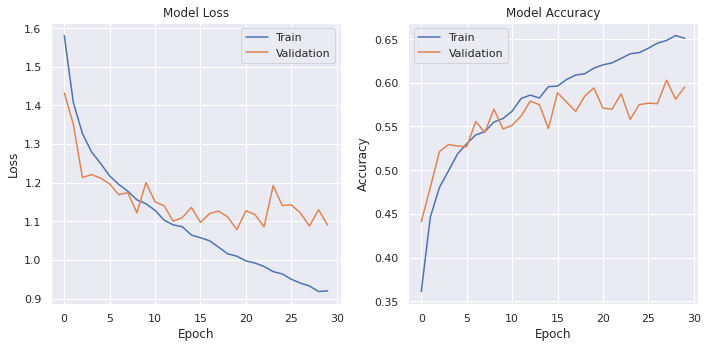

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

205/205 [==============================] - 3s 14ms/step - loss: 1.1114 - accuracy: 0.5961
Model loss: 1.111398696899414
Model accuracy 0.5961096882820129


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

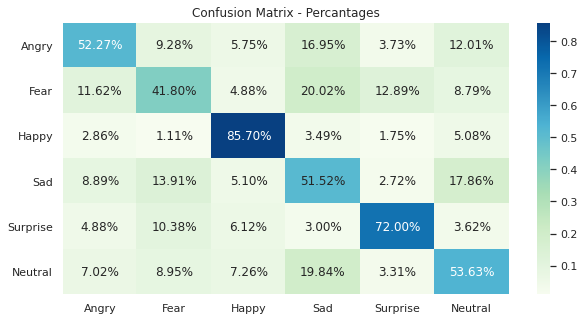

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a little difficulty classifying Angry, Fear, Sad and Neutral.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning + Fine Tuning using EfficientNetB0",
               "Data without disgust class"] = model_eval[1]

#### ***Model 9 - Transfer Learning using InceptionResNetV2***


We will create a deep neural network model to predict for each image its label  using transfer learning with a pre-trained InceptionResNetV2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 96 x 96 x 3 because Xception model expects rgb images bigger than 75 x 75.
- Use InceptionResNetV2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images_without_disgust, labels_without_disgust, test_size=0.20,
    random_state=42, stratify=labels_without_disgust)

# resize images and change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.inception_resnet_v2.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.inception_resnet_v2.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 6)
y_test = keras.utils.to_categorical(labels_test, 6)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 96 X 96 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- InceptionResNetV2 without its top layers (classification layers)
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.InceptionResNetV2(
    weights='imagenet', input_shape=(96, 96, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(96, 96, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(6, activation='softmax')
    ]
)
model.summary()

219062272/219055592 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_7 (RandomFlip)   (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation_7 (RandomRot (None, 96, 96, 3)         0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_21 (Dense)             (None, 512)               786944    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_____________________________________________________

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
653/653 [==============================] - 61s 77ms/step - loss: 1.8483 - accuracy: 0.2551 - val_loss: 1.6072 - val_accuracy: 0.3504
Epoch 2/30
653/653 [==============================] - 46s 71ms/step - loss: 1.6431 - accuracy: 0.3156 - val_loss: 1.5888 - val_accuracy: 0.3607
Epoch 3/30
653/653 [==============================] - 46s 71ms/step - loss: 1.6240 - accuracy: 0.3373 - val_loss: 1.5652 - val_accuracy: 0.3653
Epoch 4/30
653/653 [==============================] - 47s 71ms/step - loss: 1.5992 - accuracy: 0.3427 - val_loss: 1.5496 - val_accuracy: 0.3808
Epoch 5/30
653/653 [==============================] - 46s 71ms/step - loss: 1.5898 - accuracy: 0.3552 - val_loss: 1.5537 - val_accuracy: 0.3760
Epoch 6/30
653/653 [==============================] - 46s 71ms/step - loss: 1.5885 - accuracy: 0.3416 - val_loss: 1.5341 - val_accuracy: 0.3984
Epoch 7/30
653/653 [==============================] - 46s 71ms/step - loss: 1.5769 - accuracy: 0.3606 - val_loss: 1.5281 - val_accuracy:

Now, let's visualize our model performance:

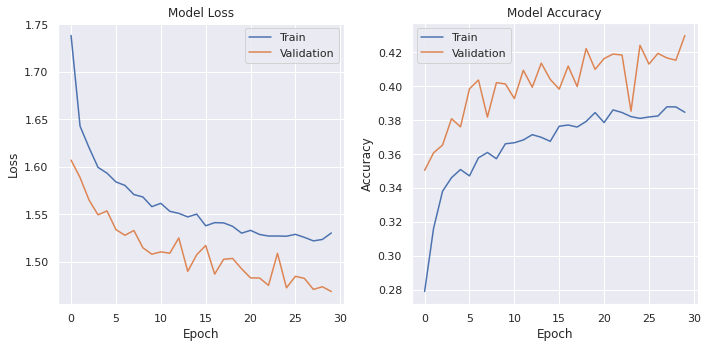

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

205/205 [==============================] - 12s 58ms/step - loss: 1.4761 - accuracy: 0.4235
Model loss: 1.4761085510253906
Model accuracy 0.42349517345428467


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

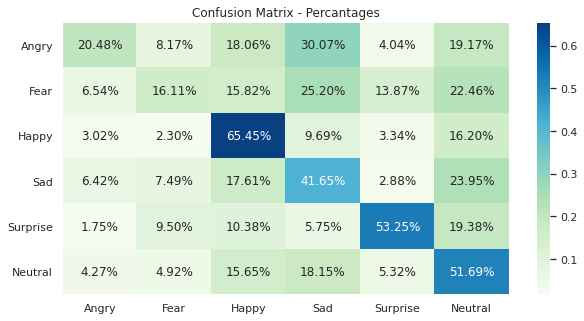

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry and Fear and also a little difficulty classifying Sad, Surprise and Neutral.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning using InceptionResNetV2",
               "Data without disgust class"] = model_eval[1]

#### ***Model 10 - Transfer Learning + Fine Tuning using InceptionResNetV2***


We will create a deep neural network model to predict for each image its label  using transfer learning and fine tuning with a pre-trained InceptionResNetV2 model.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- Reshape images to 96 x 96 x 3 because Xception model expects rgb images bigger than 75 x 75.
- Use InceptionResNetV2 preprocess_input for images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images_without_disgust, labels_without_disgust, test_size=0.20,
    random_state=42, stratify=labels_without_disgust)

# resize images and change to rgb
x_train: np.ndarray = np.asarray(
    [keras.applications.inception_resnet_v2.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.inception_resnet_v2.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_test])

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 6)
y_test = keras.utils.to_categorical(labels_test, 6)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 96 X 96 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- InceptionResNetV2 without its top layers (classification layers) - with trainable layers to allow fine tuning.
- Our classification layer.

In [ ]:
# base model for transfer learning
base_model: keras.Model = keras.applications.InceptionResNetV2(
    weights='imagenet', input_shape=(96, 96, 3),
    include_top=False, pooling='avg')

# freeze the base_model so it will not train
base_model.trainable = False

# create new model
model: keras.Model = keras.models.Sequential(
    [
     # input layer
     keras.Input(shape=(96, 96, 3)),
     # Augmentation layer - horizontal flip
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     # Augmentation layer - rotation
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     # Xception model
     base_model,
     # fully connected layers
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(512, activation="relu"),
     keras.layers.Dropout(0.25),
     # classification layer
     keras.layers.Dense(6, activation='softmax')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 96, 96, 3)         0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
653/653 [==============================] - 95s 82ms/step - loss: 1.8645 - accuracy: 0.2551 - val_loss: 1.6431 - val_accuracy: 0.3088
Epoch 2/30
653/653 [==============================] - 49s 75ms/step - loss: 1.6639 - accuracy: 0.3075 - val_loss: 1.5866 - val_accuracy: 0.3511
Epoch 3/30
653/653 [==============================] - 49s 75ms/step - loss: 1.6313 - accuracy: 0.3233 - val_loss: 1.5401 - val_accuracy: 0.3728
Epoch 4/30
653/653 [==============================] - 48s 74ms/step - loss: 1.6099 - accuracy: 0.3402 - val_loss: 1.5421 - val_accuracy: 0.3925
Epoch 5/30
653/653 [==============================] - 48s 73ms/step - loss: 1.5897 - accuracy: 0.3421 - val_loss: 1.5335 - val_accuracy: 0.3864
Epoch 6/30
653/653 [==============================] - 47s 73ms/step - loss: 1.5766 - accuracy: 0.3580 - val_loss: 1.5311 - val_accuracy: 0.3936
Epoch 7/30
653/653 [==============================] - 48s 73ms/step - loss: 1.5709 - accuracy: 0.3546 - val_loss: 1.5137 - val_accuracy:

Now, let's visualize our model performance:

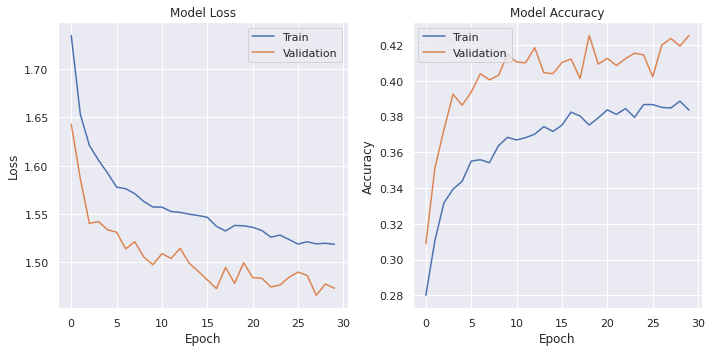

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

205/205 [==============================] - 12s 59ms/step - loss: 1.4864 - accuracy: 0.4154
Model loss: 1.4864380359649658
Model accuracy 0.41537755727767944


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

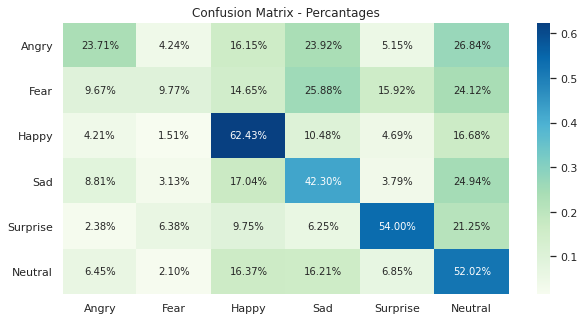

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have a big difficulty classifying Angry and Fear and also a little difficulty classifying  Sad, Surprise and Neutral.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Transfer Learning + Fine Tuning using InceptionResNetV2",
               "Data without disgust class"] = model_eval[1]

#### ***Model 11 - Self Made CNN***

Because all pre trained model expect and rgb image We will create a simple deep neural network model that expects a 2-d image to predict for each image its label.

We begin with spliting our data into train and test data. Then, we preprocess the images:
- expand image dimension to 48 X 48 X 1 - in order to have 3 dimensions.
- normalize images.
- Create one hot of labels for model training.

In [ ]:
# define arrays
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

# split data
images_train, images_test, labels_train, labels_test = train_test_split(
    images_without_disgust, labels_without_disgust, test_size=0.20, 
    random_state=42, stratify=labels_without_disgust)

# normalize images
x_train: np.ndarray = images_train / 255.0
x_test: np.ndarray = images_test / 255.0

# expand image dimension
x_train: np.ndarray = x_train.reshape(x_train.shape + (1,))
x_test: np.ndarray = x_test.reshape(x_test.shape + (1,))

# convert class vectors (integers) to binary class matrix
y_train = keras.utils.to_categorical(labels_train, 6)
y_test = keras.utils.to_categorical(labels_test, 6)

Next, we build the a cnn model to predict our image labels:

In [ ]:
# create new model
model: keras.Model = keras.models.Sequential(
    [
     # Block 1
     keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                         padding='same', input_shape=(48,48, 1)),
     keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                         padding='same'),
     keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     keras.layers.BatchNormalization(),

     # Block 2
     keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                         padding='same'),
     keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                         padding='same'),
     keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     keras.layers.BatchNormalization(),

     # Block 3
     keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',
                         padding='same'),
     keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',
                         padding='same'),
     keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     keras.layers.BatchNormalization(),

     # Flattens the input for FC
     keras.layers.Flatten(),

     # fully connected layers
     keras.layers.Dense(750, activation='relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(850, activation='relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(850, activation='relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(750, activation='relu'),
     keras.layers.Dropout(0.5),

     # classification layer
     keras.layers.Dense(6, activation='softmax')
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_203 (Conv2D)          (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_206 (Conv2D)          (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)       

Now, let's compile the model using categorical crossentropy because this is a multi-class classification task:

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Next, let's train the model:

In [ ]:
# path to save best model weights
checkpoint_file_path = '/content/checkpoint'

# model check point to save best model weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# start training
history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=50, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
653/653 [==============================] - 11s 15ms/step - loss: 2.0644 - accuracy: 0.1924 - val_loss: 1.7176 - val_accuracy: 0.2587
Epoch 2/50
653/653 [==============================] - 9s 14ms/step - loss: 1.7234 - accuracy: 0.2445 - val_loss: 1.6348 - val_accuracy: 0.3322
Epoch 3/50
653/653 [==============================] - 9s 14ms/step - loss: 1.5979 - accuracy: 0.3300 - val_loss: 1.4779 - val_accuracy: 0.3957
Epoch 4/50
653/653 [==============================] - 9s 14ms/step - loss: 1.4831 - accuracy: 0.3799 - val_loss: 1.4201 - val_accuracy: 0.4404
Epoch 5/50
653/653 [==============================] - 10s 15ms/step - loss: 1.3901 - accuracy: 0.4369 - val_loss: 1.3808 - val_accuracy: 0.4635
Epoch 6/50
653/653 [==============================] - 10s 15ms/step - loss: 1.3532 - accuracy: 0.4604 - val_loss: 1.7597 - val_accuracy: 0.3155
Epoch 7/50
653/653 [==============================] - 10s 15ms/step - loss: 1.2830 - accuracy: 0.4888 - val_loss: 1.3432 - val_accuracy: 0.

Now, let's visualize our model performance:

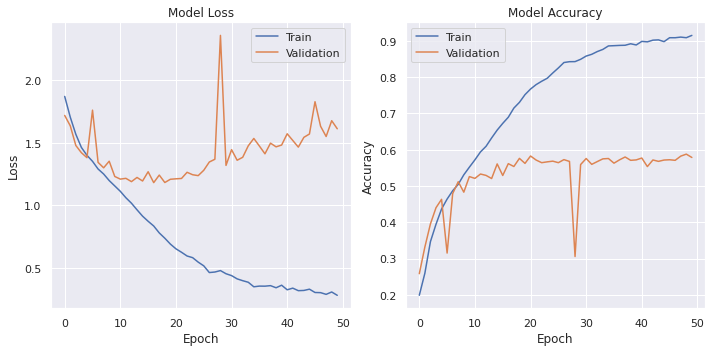

In [ ]:
# create sub plot
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# add loss plot
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')


# add accuracy plot
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# plot
plt.tight_layout()
plt.show()

We can see the training process and there is no overfitting. In order to really know how good our model is, we need to evaluate its performance on the test-set. Let's see how well it can predict the labels:

In [ ]:
# load best weights from training
model.load_weights(checkpoint_file_path)

# evalute model on test data
model_eval: List[float] = model.evaluate(x_test, y_test) 
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

205/205 [==============================] - 1s 6ms/step - loss: 1.6956 - accuracy: 0.5888
Model loss: 1.6956262588500977
Model accuracy 0.5887578725814819


Next, let's plot the confusion matrix in order to get a better understanding of our models predictions:

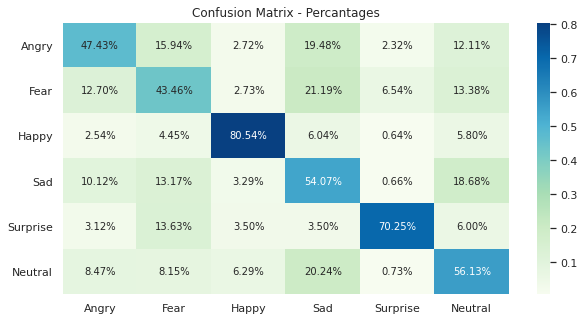

In [ ]:
# get models predictions as a single label
y_pred = np.argmax(model.predict(x_test), axis=-1)

# create confusion matrix
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

As we can see, we have  a little difficulty classifying Angry, Fear, Sad and Neutral.

Lastly, let's save model accuracy for benchmark:

In [ ]:
models_df.loc["Self Made CNN", "Data without disgust class"] = model_eval[1]

## ***Conclusion***

Let's show a comperision of all models in order to understand witch model is best by accuracy:

In [ ]:
models_df

,Data with disgust class,Data without disgust class
Transfer Learning using Xception,0.4078,0.4149
Transfer Learning + Fine Tuning using Xception,0.6485,0.6517
Transfer Learning using ResNet152V2,0.3798,0.3898
Transfer Learning + Fine Tuning using ResNet152V2,0.5551,0.2714
Transfer Learning using MobileNetV2,0.4013,0.3941
Transfer Learning + Fine Tuning using MobileNetV2,0.4771,0.4675
Transfer Learning using EfficientNetB0,0.4084,0.4122
Transfer Learning + Fine Tuning using EfficientNetB0,0.5856,0.5961
Transfer Learning using InceptionResNetV2,0.4153,0.4235
Transfer Learning + Fine Tuning using InceptionResNetV2,0.4138,0.4154


After experementing with multiple data types and models we can see we get slightly better accuracy by removing disgust but not enough to justify its removal.

Our best models with all classes are:
- Transfer Learning + Fine Tuning using Xception - Classifies Happy, Sad, Surprise, Neutral better and Angry, Disgust, Fear and Sad less.
- Transfer Learning + Fine Tuning using EfficientNetB0 - Classifies Happy, Sad, Surprise, Neutral better and Angry, Disgust, Fear less.
- Self Made CNN - Classifies Happy, Sad, Surprise, Neutral better and Angry, Disgust, Fear less.
- Transfer Learning + Fine Tuning using ResNet152V2 - Classifies Fear, Happy, Surprise, Neutral better and Angry, Disgust, Sad less.

The model for our application will be Transfer Learning + Fine Tuning using Xception.

We achieve a test accuracy of 64.85% with our best model. We are satisfied with this accuracy as the top score on the [Kaggle competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard) using this dataset achieved an accuracy of 71%. Furthermore, human scores on the FER-2013 are accuracies of 65% +/- 5% further showing that our model is very accurate.
